In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
#suppose m receptors
#suppose x bacteria
#suppose y phages
#each bacteria may have n phages bound to it
#each bacteria may have n' phages permanently bound to it
#n+n'<=m

#initialize an array containing all the available bacteria and their receptors
def initiate_bacteria(num_bacteria, receptors):
    pop = np.zeros((num_bacteria,receptors));
    return pop;
#different rows represent different bacteria
#different columns represent receptors

def data_matrix(receptors):
    #rows that says how many bacteria have nonperm
    #columns that say how many bacteria have perm
    # -- > row i and col j --> number bacteria with i nonperm, j perm
    data = np.zeros((num_bacteria+1,num_bacteria+1))
    return data;

def update_data(data,pop):
    #calculate number of 1s and -1s for each row
    nonperm = np.sum(pop==1,axis=1) #gives number of 1s for each row of pop
    perm = np.sum(pop==-1,axis=1)   #gives number of -1s for each row of pop
    
   
    bacteria = np.array([nonperm,perm])
    bacteria = bacteria.reshape((2,len(nonperm)))

    
    #first row of bacteria says nonperm
    #second row of bacteria says perm
    
    unique,index,counts = np.unique(bacteria,return_index = True,
                                    return_counts=True,axis=1)  #np.unique also sorts

    
    
    for ind in range(len(unique[0])):
     
        b = unique[:,ind]
        i = b[0]
        j = b[1]
        data[i,j] = counts[ind]
        ind += 1
        
    return data;



Probability $P_0$ that nothing happens within the infinitesimal timeframe
$$P_0(\tau,i) = rx_i \cdot k_i \cdot exp[\sum_i{rx_i\cdot k_i\cdot\tau}] $$

$\tau$ is defined as:
$$\tau = \frac{1}{\sum_i{r \cdot x_i \cdot k_i}} ln({\frac{1}{r}})$$

where $r_i = unif(0,1), x_i \text{ is the reaction and } k_i \text{ is the respective kinetic rate.}$

In [12]:
def gillespie_test(pop,num_phages,k1,k2,k3):
    #k1 = assoicate
    #k2 = dissociate
    #k3 = perm
    #time is an array of size t, 
    empty = np.sum(pop==0,axis=1)   #prob of empty -> nonperm weighted on number of empty
    nonperm = np.sum(pop==1,axis=1) #prob of nonperm -> perm weighted on number of nonperm
    perm = np.sum(pop==-1,axis=1)   #prob of nonpperm ->empty weighted on number of nonperm
    
    species = np.stack((empty,nonperm,perm),axis=1) 
    
    
    #each row of species is a bacteria with i empty, j nonperm and k perm
    #unique,index,counts = np.unique(species, return_counts=True,return_index = True, axis=0)
    
    #prob of nothing occuring within time_step for each column (bacteria)
    
        
    #calculate next time_step
    #find ratio of bacteria to phages (MOI)
    moi = num_phages/len(pop) #this will be the number of infective phages per bacteria
    
    #calculate a time step by the weights of every bacteria
    prob_rows = np.zeros((len(species)))
    r = np.random.uniform()
    denom = 0
    
    for b in range(len(species)):
        s = species[b]
        i = s[0]
        j = s[1]
        d = (i*k1*moi + j*k2 + j*k3)  #sum of all three reactions for each row
        denom = denom + d  # total all the reaction possibilities over all rows
        
        #each bacteria has a weight for likeliness of reaction to occur
        #then within each bacteria we will choose a reaction to occur
        
    tau = abs(np.log(1/r)/(r*denom)) #calculated from all the bacteria
  
    
    for c in range(len(species)):
        s = species[c]
        i = s[0]
        j = s[1]
        p1 = k1*moi*i    #prob empty  --> adhere
        p2 = k2*j        #prob adhere --> empty
        p3 = 1-p1-p2     #prob adhere --> perm
        # prob of some reaction occuring per bacteria
        p_not = r*(p1+p2+p3)*np.exp(denom*tau)
        prob_rows[c] = p_not
    
    #from prob_rows, we sample to find what index (bacteria) will experience a reaction
    #weighted on the likeliness of a reaction occuring for that bacteria
    #then based on the features of the bacteria, we pick the most likely reaction to occur
 

    #Gillespie math is to be checked  This is just a rough run
    
    prob_rows /= prob_rows.sum()
    prob_rows = np.nan_to_num(prob_rows)
    #print(prob_rows)
    
    
    boold = set(prob_rows==0)
    if True in boold:
        prob_rows[prob_rows == 0] = 1/len(species)
        #print(prob_rows)
    
    ###current issue:  sometimes probabilities go to 0 or infinitity,
    ###don't know how to handle these
    ###for now made it uniform but then it chooses rxns that should be impossible
    ###must fix
    ###happy the code works in general now though
    
    pick_bact = np.random.choice(list(range(len(species))),1,False,prob_rows) [0]

    bact = pop[pick_bact]
    
    rxn = species[pick_bact]
    
    rx1 = k1*moi*rxn[0]      #number of empty receptors   --> nonperm
    rx2 = k2*rxn[1]          #number of nonperm receptors --> empty
    rx3 = k3*rxn[1]          #number of nonperm receptors --> perm
    rweights = np.array([rx1,rx2,rx3])
    
    rweights/=rweights.sum()
    rweights = np.nan_to_num(rweights)
    #print(rweights)
    #if True in set(rweights == 0):
        

    
    pick_rxn = np.random.choice([0,1,2],1,False,rweights)
    
    if pick_rxn == 0:
        #add phage to this row's pop: change a 0 to 1
        #remove phage from population
        num_phages -= 1
        a = np.where(bact == 0)[0][0]  #change first index of 0 to 1
        bact[a] = 1
        #print('add')
        
    if pick_rxn == 1:
        #release a nonperm phage:  change a 1 to 0
        #add phage back to population
        num_phages +=1
        a = np.where(bact == 1)[0][0]  #change first index of 1 to 0
        bact[a] = 0
        #print('loss')
        
    if pick_rxn == 2:
        #perm bound nonperm phage: change 1 to -1
        a = np.where(bact == 1)[0][0]  #change first index of 1 to -
        bact[a] = -1
        #print('perm')
    
    #print(a)
    #print('------------bact-------------')
    #print(bact)
        
    #update population
    pop[pick_bact] = bact

    
        
    return pop,num_phages,tau;
    

#0-->no phage bound
#1-->phage non-perm bound
#-1-->phage perm bound

#Gillespie chooses which row to update based on equations array
# * If no phages bound, randomly choose index to 1
# * If multiple phages bound, and either dissociation or perm,
#    randomly choose index == 1 to change to 0 or -1
# * At the end of each round, calculate the number of nonzero indices == bounded phages
# * For each row, calculate the number of 1s, and -1s.
# * Count how many unique species there are, and their amount
# * Update data matrix based on number of 1s and -1s for each row


In [17]:
#establish variables
tot_time = 8000
num_bacteria = 500
num_phages = 100000
k1,k2,k3 = 0.93e-11,1.9e-3,1e-3      #kinetic rate constants
receptors = 150
time = np.zeros((tot_time))
pop = initiate_bacteria(num_bacteria,receptors)
data = data_matrix(receptors)
#establish data matrix data_all
data_all = np.zeros((tot_time,num_bacteria+1,num_bacteria+1))

#run algorithm
for t in range(tot_time):
    print('time step: {}'.format(t))
    print('number phages: {}'.format(num_phages))
    pop,num_phages,delta_t = gillespie_test(pop,num_phages,k1,k2,k3)
    time[t] = time[t-1]+delta_t
    print('change in time: {}'.format(time[t]))
    data_all[t] = update_data(data,pop)
    data = data_all[t]
    
    
    if num_phages == 0:
        break;
    
print(num_phages)
    



time step: 0
number phages: 100000
change in time: 22108.597290627284
time step: 1
number phages: 99999
change in time: 49695.93112321834
time step: 2
number phages: 99998
change in time: 51605.17504851626
time step: 3
number phages: 99997
change in time: 53950.36524295699
time step: 4
number phages: 99996
change in time: 54408.200593307134
time step: 5
number phages: 99995
change in time: 54474.42099934627
time step: 6
number phages: 99994
change in time: 54740.86860803408
time step: 7
number phages: 99993
change in time: 54780.092504053195
time step: 8
number phages: 99992
change in time: 55201.47152292054
time step: 9
number phages: 99991
change in time: 55235.10757226021
time step: 10
number phages: 99990
change in time: 55274.51645244322
time step: 11
number phages: 99989
change in time: 55326.86867960649
time step: 12
number phages: 99988
change in time: 55344.13352908404
time step: 13
number phages: 99987
change in time: 55354.396813648666
time step: 14
number phages: 99986
chan

c:\users\nick\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp
c:\users\nick\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide



number phages: 99934
change in time: 83009.60388907176
time step: 72
number phages: 99933
change in time: 83014.31390471556
time step: 73
number phages: 99932
change in time: 83183.01747912416
time step: 74
number phages: 99931
change in time: 83347.97537208615
time step: 75
number phages: 99930
change in time: 83349.43994521126
time step: 76
number phages: 99929
change in time: 83413.96770980264
time step: 77
number phages: 99928
change in time: 83418.66507894499
time step: 78
number phages: 99929
change in time: 83420.35807507792
time step: 79
number phages: 99928
change in time: 83424.82139543246
time step: 80
number phages: 99927
change in time: 83430.90307591976
time step: 81
number phages: 99926
change in time: 83431.32077708274
time step: 82
number phages: 99925
change in time: 83434.45026293944
time step: 83
number phages: 99924
change in time: 83439.44543349759
time step: 84
number phages: 99923
change in time: 83446.36856792949
time step: 85
number phages: 99924
change in ti

In [18]:
print(data_all[-1])

[[11. 54. 57. ...  0.  0.  0.]
 [13. 38. 62. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


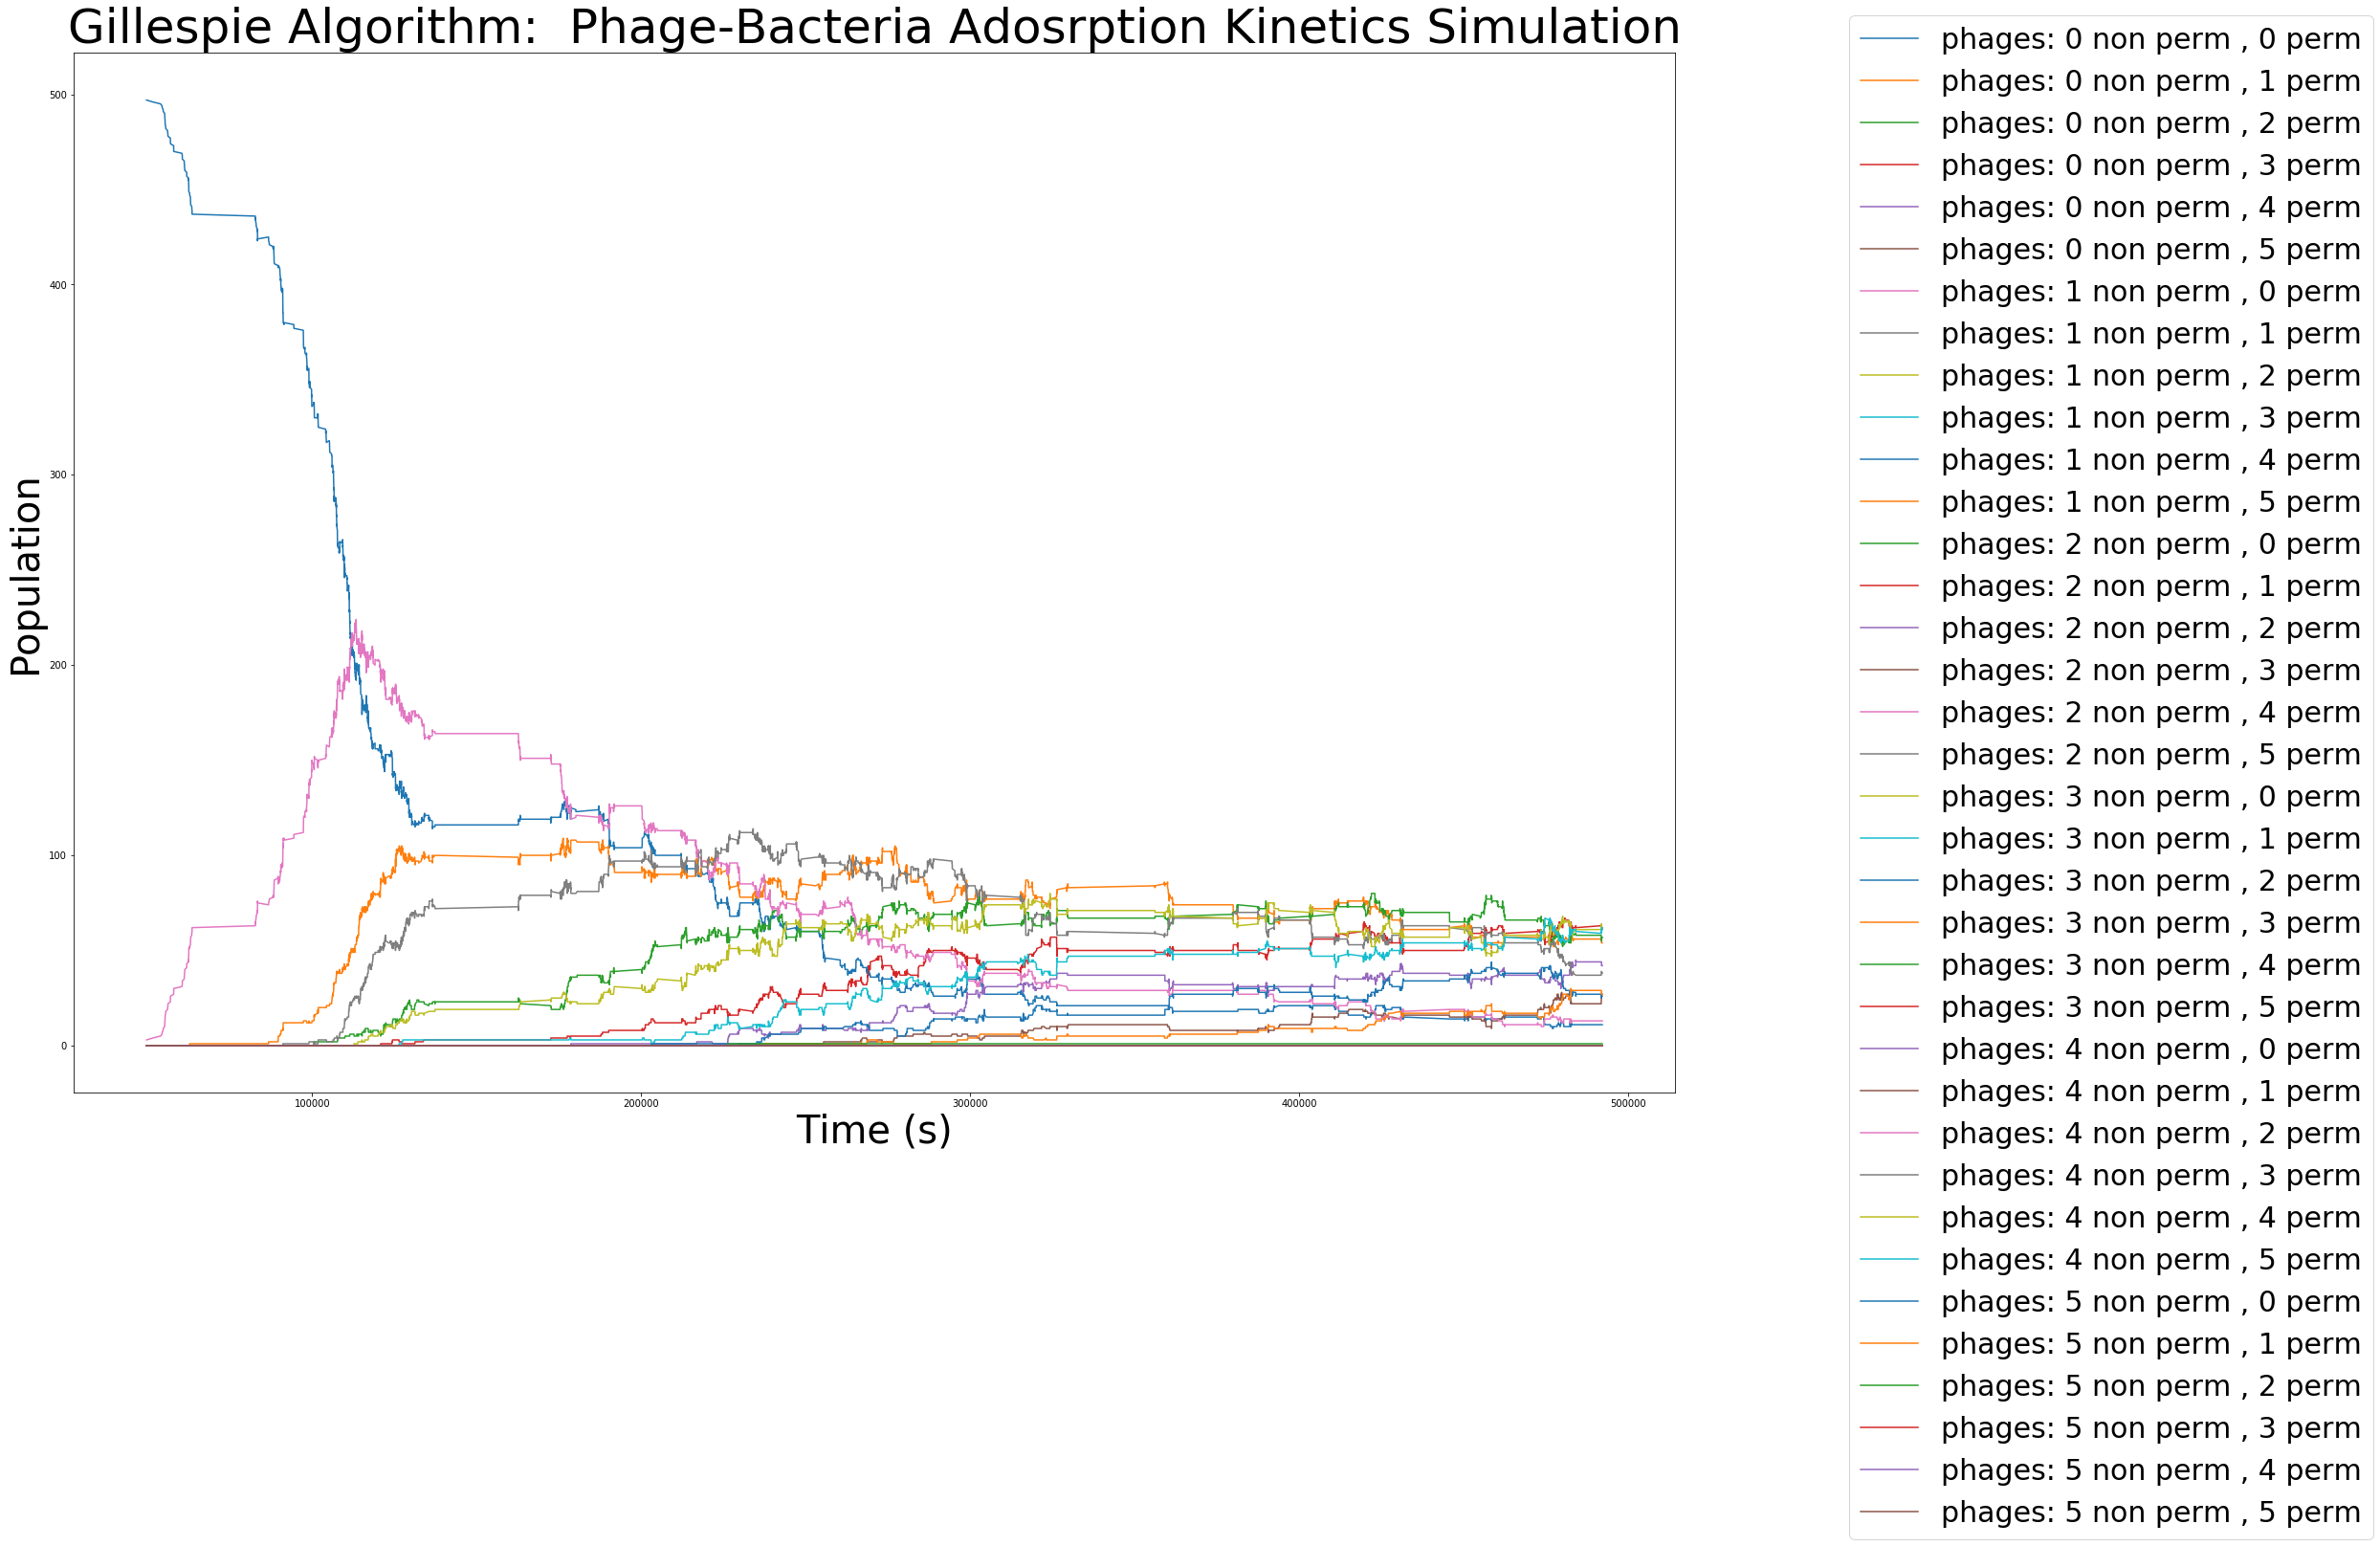

In [21]:
plt.figure(figsize=[30,20])
plt.xlabel('Time (s)',fontsize=40)
plt.ylabel('Population',fontsize=40)
plt.title('Gillespie Algorithm:  Phage-Bacteria Adosrption Kinetics Simulation',fontsize=50)
for i in range(6):  #  nonperm
    for j in range(6):# perm
        plt.plot(time[1:8000],data_all[1:8000,i,j],label = 'phages: {} non perm , {} perm'.format(i,j))
plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=30)

In [ ]:
#cumulative plot of any phage bound to bacteria???
